# Estimation of effective connectivity (EC) using MOU process for model
## Replication of results from the paper by [Senden et al. (2017)](#references)
This Python notebook aims to reproduce the results presented in the abovementioned paper. As the fundamental approach utilized in the paper matches exactly the one applied in a closely related project by Gilson et al. (ct. [MOUEC-Estimation notebook by Gilson et al. (2019)](#references)), the code is heavily influenced by and partly taken from this source (explicit indications are not provided in this provisional version). The class MOU (multivariate Ornstein-Uhlenbeck) from the [*pyMOU* library](#references) (pymou.mou_model), which is used in that project, was adapted to match the procedure described in the paper to be reproduced (slightly different process model). The changes exclusively effect the method fit_LO().

The files listed below are required to be positioned in the same location the main file *replicate_results_from_Senden_et_al_paper.ipynb* is located. 
- *mou_model.py* (The adapted version of the eponymous file from the [*pyMOU* library](#references).)
- *DATA_TASK_3DMOV_HP_CSF_WD.mat* (BOLD time series (funtional data) and ROI lables.)
- *BINARY_EC_MASK.mat* (Anatomical connectome averaged over subjects (structural data).)

In [155]:
## Import dependencies.
import os
import itertools
from scipy.io import loadmat, savemat, matlab
import scipy.stats as stt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mou_model import MOU

%matplotlib inline

## Introduce constants.
_RES_DIR = 'model_parameter/'
_I_REST_RUN = 0
_I_NBACK_RUN = 1
_I_NO_TIMESHIFT = 0
_I_ONE_TIMESHIFT = 1
_SUBJECT_AXIS = 0

## Create a local folder to store results.
if not os.path.exists(_RES_DIR):
    print('created directory:', _RES_DIR)
    os.makedirs(_RES_DIR)
    
## Flags
multiple_runs_flag = False # If == False, data with just one run is expected
examine_patients_flag = True # If == False, control participants are examined
io_based_on_nodal_degree_flag = False
allow_all_connections_for_EC_flag = False
optimize_with_FC_version = 'FC_scaled_avg' #'FC_scaled_avg','FC_avg_scaled'or'FC_avg'
plot_FC_scaled_avg_flag = False # If == False, FC_avg_scaled is printed
input_is_rowsum_flag = False # If == False, input = columnsum

In [156]:
## The following function was retrieved from 
# https://stackoverflow.com/questions/48970785/complex-matlab-struct-mat-file-read-by-python
# unchanged except from the prints, which were added to give the user a rough 
# idea of the data's structure.
def load_mat(filename):
    """
    This function should be called instead of direct scipy.io.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects.
    """

    def _check_vars(d):
        """
        Checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in d:
            if isinstance(d[key], matlab.mio5_params.mat_struct):
#                print(key)
                d[key] = _todict(d[key])
            elif isinstance(d[key], np.ndarray):
#                print(key)
                d[key] = _toarray(d[key])
        return d

    def _todict(matobj):
        """
        A recursive function constructing nested dictionaries from matobjects
        """
#        print('\tcontaining another dictionary with the keys')
        d = {}
        for strg in matobj._fieldnames:
#            print('\t', strg)
            elem = matobj.__dict__[strg]
            if isinstance(elem, matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _toarray(elem)
            else:
                d[strg] = elem
        return d

    def _toarray(ndarray):
        """
        A recursive function which constructs ndarray from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        """
#        print('\t\tcontaining an array\n\t\t\tof shape', ndarray.shape, 
#              '\n\t\t\tand dtype', ndarray.dtype)
        if ndarray.dtype != 'float64':
            elem_list = []
            for sub_elem in ndarray:
                if isinstance(sub_elem, matlab.mio5_params.mat_struct):
                    elem_list.append(_todict(sub_elem))
                elif isinstance(sub_elem, np.ndarray):
                    elem_list.append(_toarray(sub_elem))
                else:
                    elem_list.append(sub_elem)
            return np.array(elem_list)
        else:
            return ndarray
        
    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
 #   print('The data in', filename, 'consists of', len(data.keys()) - 3,
 #         'element(s) with the following keys:\n')
    return _check_vars(data)

### Data set
The data set consists of 5 sessions for 14 subjects: one each for rest, the n-back task, the flanker task, the mental rotation task, and the odd-man out task. Each session is about 6 minutes long and consists of 192 time points (fMRI time resolution TR = 2 seconds). The parcellation corresponds to the Desikan-Killany (DK) atlas (Desikan et al., 2006; Klein & Tourville, 2012) with 68 regions of interest (ROIs).
The preprocessed fMRI data was downloaded from https://datadryad.org/stash/dataset/doi:10.5061/dryad.mc7pd. For more detailed information concerning the data follow the link above.

The data files are:
 - *DATA_TASK_3DMOV_HP_CSF_WD.mat* (BOLD time series (funtional data) and ROI lables)
 - *BINARY_EC_MASK.mat* (anatomical connectome averaged over subjects (structural data))

As the data format of the preprocessed data is different to the one in the aforementioned notebook by Gilson ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)), it is restructured to match the format of the latter for enhanced comparability.

In [205]:
## Read in data and structure it.
# Read in ROI labels from Senden Paper to compare the order.
fMRI_data_and_labels = load_mat(
    'BOLD_data_and_SC_matrix/DATA_TASK_3DMOV_HP_CSF_WD')
keys_1st_layer = list(fMRI_data_and_labels.keys())
regionalized_preprocessed_fMRI_data = fMRI_data_and_labels[keys_1st_layer[3]]
roi_labels = fMRI_data_and_labels[keys_1st_layer[4]]
# Read in SZ data.
fMRI_data = load_mat(
    'schizophrenics_data_and_data_description/cobre_schizo_aparc_ts')
keys_1st_layer = list(fMRI_data.keys())
data_per_subj = fMRI_data[keys_1st_layer[3]]
keys_2nd_layer = list(data_per_subj[0].keys())
#print('Subject with complete data, have the following keys:', str(keys_2nd_layer))
n_subjects = len(data_per_subj)
n_ts_samples, n_rois = data_per_subj[0]['timeseries'].shape 

#roi_labels = regionalized_preprocessed_fMRI_data[keys_2nd_layer[0]]
#regionalized_preprocessed_fMRI_data = fMRI_data_and_labels[keys_1st_layer[3]]
#roi_labels = fMRI_data_and_labels[keys_1st_layer[4]]
#run_labels = list(regionalized_preprocessed_fMRI_data.keys())
#first_run_data = regionalized_preprocessed_fMRI_data[run_labels[0]]
#
#
## Display the ROI labels
#print('\nR'+'\u0332'+'egions O'+'\u0332'+'f I'+'\u0332'+'nterest (ROIs): \n')
#for i,i_roi in enumerate(roi_labels): 
#    print(f'{i:2d} : {i_roi}')
## The fMRI data properties.
#n_subjects = first_run_data.shape[2]
#n_runs = len(regionalized_preprocessed_fMRI_data)
#n_rois = first_run_data.shape[1]
#n_ts_samples = first_run_data.shape[0]
## Restructure data.
#filtered_ts_emp = np.zeros([n_subjects, n_runs, n_rois, n_ts_samples])
#for i,i_run in enumerate(run_labels):
#    filtered_ts_emp[:, i, :, :] = np.transpose(
#        regionalized_preprocessed_fMRI_data[i_run], (2, 1, 0))




## Chose only subjects for whom the full timeseries is present
timeseries = np.zeros([n_subjects, n_ts_samples, n_rois])
for i, i_subj in enumerate(data_per_subj):
    #print(i, '\t\t:', i_subj.keys())
    timeseries[i, :, :] = i_subj.get('timeseries')

## Exclude subjects who are marked for exclusion
subj_infos = pd.read_excel(
    'schizophrenics_data_and_data_description/cobre_schizoprenia.xlsx', header = 1)
mask_exclude_subj = subj_infos.loc[: , "Exlude?"]
mask_exclude_subj = mask_exclude_subj.replace("Motion",1)
mask_exclude_subj = mask_exclude_subj.replace("Disenrolled",1)
mask_exclude_subj = mask_exclude_subj.replace("Incomplete",1)
mask_exclude_subj = mask_exclude_subj.replace(np.nan,0)
mask_exclude_subj = mask_exclude_subj.to_numpy(dtype=bool)
true_timeseries = timeseries[~mask_exclude_subj]

## Separate healthy participants from schizophrenics
participant_type_labels = ["Control", "Patient"]
mask_patient_subj = subj_infos.loc[: , "Subject Type"]
mask_patient_subj = mask_patient_subj.replace(participant_type_labels[0],0)
mask_patient_subj = mask_patient_subj.replace(participant_type_labels[1],1)
mask_patient_subj = mask_patient_subj.to_numpy(dtype=bool)
mask_patient_subj = mask_patient_subj[~mask_exclude_subj]
patients_timeseries = true_timeseries[mask_patient_subj]
patients_timeseries = patients_timeseries[
    np.logical_not(np.isnan(patients_timeseries))].reshape((-1,150,68))
control_timeseries = true_timeseries[~mask_patient_subj]
controls_timeseries = control_timeseries[
    np.logical_not(np.isnan(control_timeseries))].reshape((-1,150,68))
print('Participants with complete data:')
print('\t', patients_timeseries.shape[0], 'patient participants')
print('\t', controls_timeseries.shape[0], 'control participants')

if multiple_runs_flag:
    n_subjects, n_runs, n_rois, n_ts_samples = filtered_ts_emp.shape
else:
    filtered_ts_patients = np.transpose(patients_timeseries, (0, 2, 1))
    filtered_ts_controls = np.transpose(controls_timeseries, (0, 2, 1))
    n_subjects_patients, n_rois_patients, n_ts_samples_patients = \
    filtered_ts_patients.shape
    n_subjects_controls, n_rois_controls, n_ts_samples_controls = \
    filtered_ts_controls.shape
    
# Confirm that the order and the names of regions is the same for the EC-mask
# and the BOLD-dat
labels = pd.read_excel(
    'schizophrenics_data_and_data_description/cobre_schizoprenia.xlsx', 
    sheet_name='regions', usecols='C', header=1)
labels = labels.replace({'ctx-':''}, regex=True)
labels = labels.replace({' ':''}, regex=True)
labels = labels.replace({'-':'_'}, regex=True)
labels = np.concatenate(labels.to_numpy())
print('The order and names of ROIs is the some for both, \
EC mask and BOLD data:', (labels == roi_labels).all())

Participants with complete data:
	 60 patient participants
	 69 control participants
The order and names of ROIs is the some for both, EC mask and BOLD data: True


In [199]:
#with np.printoptions(threshold=np.inf):
#    print(true_timeseries[1:16])
n_runs=1
np.squeeze(np.zeros([n_subjects, n_runs, n_rois, n_rois])).shape

['lh_bankssts' 'lh_caudalanteriorcingulate' 'lh_caudalmiddlefrontal'
 'lh_cuneus' 'lh_entorhinal' 'lh_fusiform' 'lh_inferiorparietal'
 'lh_inferiortemporal' 'lh_isthmuscingulate' 'lh_lateraloccipital'
 'lh_lateralorbitofrontal' 'lh_lingual' 'lh_medialorbitofrontal'
 'lh_middletemporal' 'lh_parahippocampal' 'lh_paracentral'
 'lh_parsopercularis' 'lh_parsorbitalis' 'lh_parstriangularis'
 'lh_pericalcarine' 'lh_postcentral' 'lh_posteriorcingulate'
 'lh_precentral' 'lh_precuneus' 'lh_rostralanteriorcingulate'
 'lh_rostralmiddlefrontal' 'lh_superiorfrontal' 'lh_superiorparietal'
 'lh_superiortemporal' 'lh_supramarginal' 'lh_frontalpole'
 'lh_temporalpole' 'lh_transversetemporal' 'lh_insula' 'rh_bankssts'
 'rh_caudalanteriorcingulate' 'rh_caudalmiddlefrontal' 'rh_cuneus'
 'rh_entorhinal' 'rh_fusiform' 'rh_inferiorparietal' 'rh_inferiortemporal'
 'rh_isthmuscingulate' 'rh_lateraloccipital' 'rh_lateralorbitofrontal'
 'rh_lingual' 'rh_medialorbitofrontal' 'rh_middletemporal'
 'rh_parahippocampa

True

### Functional connectivity (FC)
As the BOLD covariances "are natural objective functions for the MOU model," ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) they are used as  functional connectivity here. The BOLD time series are zero-centered in order to eliminate offset differences between runs.

In [159]:
### Length of BOLD data dependent on tau like in tau_lag_correlation.m.
## Calculate functional connectivity (BOLD covariances) [Q0 and Q1].
def calculate_FC_shift(filtered_ts_emp, n_shifts, multiple_runs_flag=True, 
                       **kwargs):
    if multiple_runs_flag:
        n_subjects, n_runs, n_rois, n_ts_samples = filtered_ts_emp.shape
        FC_shift = np.zeros([n_subjects, n_runs, n_rois, n_rois])
        FC_Reuters = np.zeros([n_subjects, n_runs, n_rois, n_rois])
        n_ts_span = n_ts_samples - n_shifts
        for i_subject in range(n_subjects):
            for i_run in range(n_runs):
                # Center the time series (around zero).
                filtered_ts_emp[i_subject, i_run, :, :] -=  \
                        np.outer(filtered_ts_emp[i_subject, i_run, :, :].
                                 mean(axis=1), np.ones([n_ts_samples]))
                # Calculate covariances with one time shift.
                for i_roi in range(n_rois):
                    FC_shift[i_subject, i_run, :, i_roi] = \
                    np.dot(filtered_ts_emp[i_subject, i_run, :,
                                           :n_ts_span], 
                           filtered_ts_emp[i_subject, i_run, i_roi,
                                           n_shifts:]) / float(n_ts_span)
    else:
        n_subjects, n_rois, n_ts_samples = filtered_ts_emp.shape
        FC_shift = np.zeros([n_subjects, n_rois, n_rois])
        FC_Reuters = np.zeros([n_subjects, n_rois, n_rois])
        n_ts_span = n_ts_samples - n_shifts
        for i_subject in range(n_subjects):
            # Center the time series (around zero).
            filtered_ts_emp[i_subject, :, :] -=  \
                    np.outer(filtered_ts_emp[i_subject, :, :].
                             mean(axis=1), np.ones([n_ts_samples]))
            # Calculate covariances with one time shift.
            for i_roi in range(n_rois):
                FC_shift[i_subject, :, i_roi] = \
                np.dot(filtered_ts_emp[i_subject, :,
                                       :n_ts_span], 
                       filtered_ts_emp[i_subject, i_roi,
                                       n_shifts:]) / float(n_ts_span)               
    return FC_shift

Due to the application of the min-max-scaler most of the FC values     should be between 0 and 1
Min FC0 value: -0.13414160495181565
Mean FC0 value: 0.021563133346320793
Max FC0 value: 1.0
Mean BOLD variance (diagonal of each FC0 matrix): 0.375581515654996


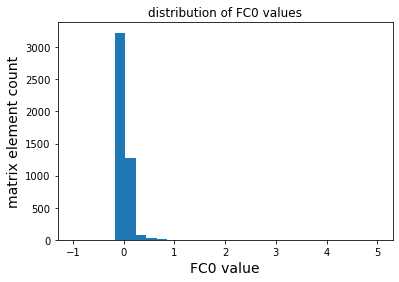

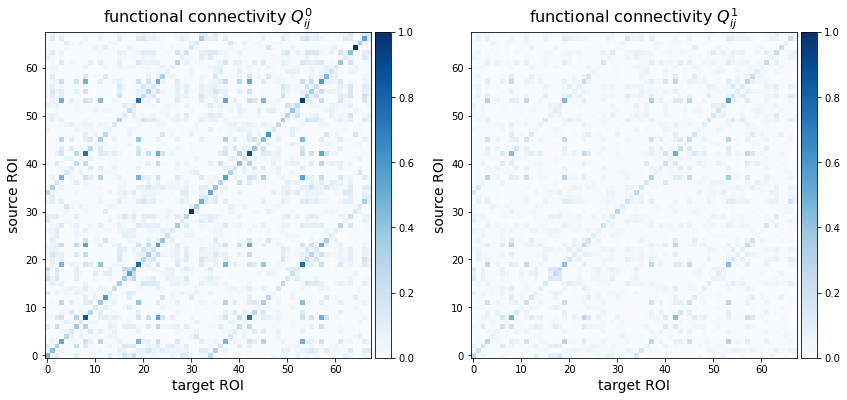

Due to the application of the min-max-scaler most of the FC values     should be between 0 and 1
Min FC0 value: -0.07162180974184862
Mean FC0 value: 0.01925293652051679
Max FC0 value: 1.0
Mean BOLD variance (diagonal of each FC0 matrix): 0.22236079562416516


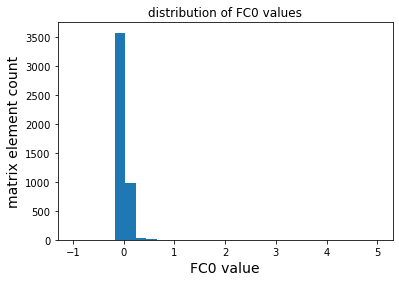

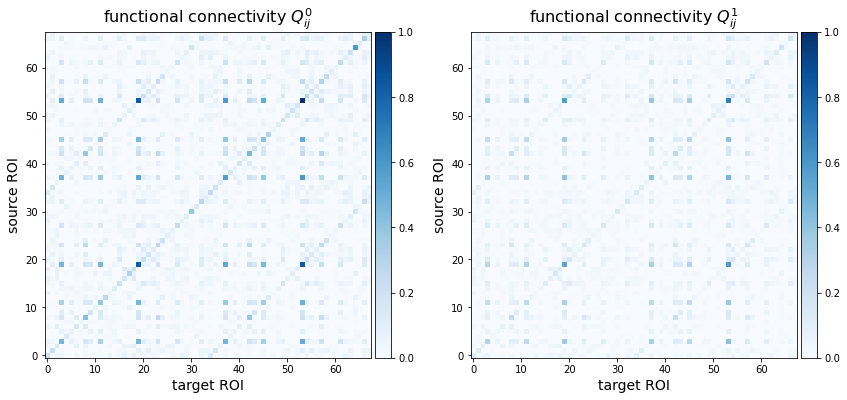

In [160]:
## Calculate functional connectivity (BOLD covariances) [Q0 and Q1].
time_shifts = np.arange(4, dtype=int)
n_shifts = len(time_shifts)
if multiple_runs_flag:
    FC = np.ndarray([n_subjects, n_runs, n_shifts, n_rois, n_rois])
    for time_shift in time_shifts:
        FC[:, :, time_shift, :, :] = calculate_FC_shift(
            filtered_ts_emp, time_shift)

    # Scale FC so that the max value of every subject's FC is 1.
    FC_scaled = FC/FC[:, :, _I_NO_TIMESHIFT,:, :].max(axis=2).max(
        axis=2).max(axis=1)[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis]
    # Visualize the effect of the scaling by printing the relevant values.
    #print('Maxima of FC_scaled:\n\n', FC_scaled.max(axis=3).max(axis=3))

    # Average FC over subjects.
    FC_avg = FC.mean(axis=_SUBJECT_AXIS)
    FC_scaled_avg = FC_scaled.mean(axis=_SUBJECT_AXIS)
    # Scale FC_avg so that the maximal value for each run is 1.
    FC_avg_scaled = FC_avg/FC_avg[:, _I_NO_TIMESHIFT,:, :].max(axis=1).max(
        axis=1)[:, np.newaxis, np.newaxis, np.newaxis]
    # Visualize the effect of the scaling by printing the relevant values.
    #print('\nMaxima of FC_avg_scaled:\n\n', FC_avg_scaled.max(axis=2).max(axis=2))

    if plot_FC_scaled_avg_flag == True:
        plotted_FC_version = FC_scaled_avg
    else:
        plotted_FC_version = FC_avg_scaled
    print('Due to the application of the min-max-scaler most of the FC values \
    should be between 0 and 1')
    print('Min FC0 value:', 
          plotted_FC_version[:, _I_NO_TIMESHIFT, :, :].min())
    print('Mean FC0 value:', 
          plotted_FC_version[:, _I_NO_TIMESHIFT, :, :].mean())
    print('Max FC0 value:', 
          plotted_FC_version[:, _I_NO_TIMESHIFT, :, :].max())
    # print('Min FC0 value:', FC0_rest_subj_avg_scaled.min())
    # print('Max FC0 value:', FC0_rest_subj_avg_scaled.max())
    print('Mean BOLD variance (diagonal of each FC0 matrix):', 
          plotted_FC_version[:, _I_NO_TIMESHIFT, :, :].diagonal(
              axis1=1, axis2=2).mean())
    # Show distibution of FC0 values.
    plt.figure()
    plt.hist(plotted_FC_version[:, _I_NO_TIMESHIFT, :, :].flatten(),
             bins=np.linspace(-1, 5, 30))
    plt.xlabel('FC0 value', fontsize=14)
    plt.ylabel('matrix element count', fontsize=14)
    plt.title('distribution of FC0 values')

    # Show FC0 averaged over subjects for the rest run.
    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    FC0_rest = plotted_FC_version[_I_REST_RUN, _I_NO_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC0_rest, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)

    # Show FC1 averaged over subjects for the rest run.
    plt.subplot(122)
    FC1_rest = plotted_FC_version[_I_REST_RUN, _I_ONE_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC1_rest, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
    plt.show()
else:
    ## Examine patient FC.
    FC_patients = np.ndarray([n_subjects_patients, n_shifts, 
                              n_rois_patients, n_rois_patients])
    for time_shift in time_shifts:
        FC_patients[:, time_shift, :, :] = calculate_FC_shift(
            filtered_ts_patients, time_shift, multiple_runs_flag=False)

    # Scale FC so that the max value of every subject's FC is 1.
    FC_patients_scaled = FC_patients/FC_patients[:, _I_NO_TIMESHIFT,:, :].max(
        axis=1).max(axis=1)[:, np.newaxis, np.newaxis, np.newaxis]
    # Visualize the effect of the scaling by printing the relevant values.
    #print('Maxima of FC_scaled:\n\n', FC_scaled.max(axis=3).max(axis=3))

    # Average FC over subjects.
    FC_patients_avg = FC_patients.mean(axis=_SUBJECT_AXIS)
    FC_patients_scaled_avg = FC_patients_scaled.mean(axis=_SUBJECT_AXIS)
    # Scale FC_avg so that the maximal value for each run is 1.
    FC_patients_avg_scaled = FC_patients_avg/FC_patients_avg[
        _I_NO_TIMESHIFT,:, :].max(axis=0).max(axis=0)[
        np.newaxis, np.newaxis, np.newaxis]
    # Visualize the effect of the scaling by printing the relevant values.
    #print('\nMaxima of FC_avg_scaled:\n\n', FC_avg_scaled.max(axis=2).max(axis=2))

    if plot_FC_scaled_avg_flag == True:
        plotted_FC_version = FC_patients_scaled_avg
    else:
        plotted_FC_version = FC_patients_avg_scaled
    print('Due to the application of the min-max-scaler most of the FC values \
    should be between 0 and 1')
    print('Min FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].min())
    print('Mean FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].mean())
    print('Max FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].max())
    # print('Min FC0 value:', FC0_rest_subj_avg_scaled.min())
    # print('Max FC0 value:', FC0_rest_subj_avg_scaled.max())
    print('Mean BOLD variance (diagonal of each FC0 matrix):', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].diagonal(
              axis1=0, axis2=1).mean())
    # Show distibution of FC0 values.
    plt.figure()
    plt.hist(plotted_FC_version[_I_NO_TIMESHIFT, :, :].flatten(),
             bins=np.linspace(-1, 5, 30))
    plt.xlabel('FC0 value', fontsize=14)
    plt.ylabel('matrix element count', fontsize=14)
    plt.title('distribution of FC0 values')

    # Show FC0 averaged over subjects.
    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    FC0 = plotted_FC_version[_I_NO_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC0, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)

    # Show FC1 averaged over subjects for.
    plt.subplot(122)
    FC1 = plotted_FC_version[_I_ONE_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC1, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
    plt.show()
    
    ## Examine control FC.
    FC_controls = np.ndarray([n_subjects_controls, n_shifts, 
                              n_rois_controls, n_rois_controls])
    for time_shift in time_shifts:
        FC_controls[:, time_shift, :, :] = calculate_FC_shift(
            filtered_ts_controls, time_shift, multiple_runs_flag=False)

    # Scale FC so that the max value of every subject's FC is 1.
    FC_controls_scaled = FC_controls/FC_controls[:, _I_NO_TIMESHIFT,:, :].max(
        axis=1).max(axis=1)[:, np.newaxis, np.newaxis, np.newaxis]
    # Visualize the effect of the scaling by printing the relevant values.
    #print('Maxima of FC_scaled:\n\n', FC_scaled.max(axis=3).max(axis=3))

    # Average FC over subjects.
    FC_controls_avg = FC_controls.mean(axis=_SUBJECT_AXIS)
    FC_controls_scaled_avg = FC_controls_scaled.mean(axis=_SUBJECT_AXIS)
    # Scale FC_avg so that the maximal value for each run is 1.
    FC_controls_avg_scaled = FC_controls_avg/FC_controls_avg[
        _I_NO_TIMESHIFT,:, :].max(axis=0).max(axis=0)[
        np.newaxis, np.newaxis, np.newaxis]
    # Visualize the effect of the scaling by printing the relevant values.
    #print('\nMaxima of FC_avg_scaled:\n\n', FC_avg_scaled.max(axis=2).max(axis=2))

    if plot_FC_scaled_avg_flag == True:
        plotted_FC_version = FC_controls_scaled_avg
    else:
        plotted_FC_version = FC_controls_avg_scaled
    print('Due to the application of the min-max-scaler most of the FC values \
    should be between 0 and 1')
    print('Min FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].min())
    print('Mean FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].mean())
    print('Max FC0 value:', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].max())
    # print('Min FC0 value:', FC0_rest_subj_avg_scaled.min())
    # print('Max FC0 value:', FC0_rest_subj_avg_scaled.max())
    print('Mean BOLD variance (diagonal of each FC0 matrix):', 
          plotted_FC_version[_I_NO_TIMESHIFT, :, :].diagonal(
              axis1=0, axis2=1).mean())
    # Show distibution of FC0 values.
    plt.figure()
    plt.hist(plotted_FC_version[_I_NO_TIMESHIFT, :, :].flatten(),
             bins=np.linspace(-1, 5, 30))
    plt.xlabel('FC0 value', fontsize=14)
    plt.ylabel('matrix element count', fontsize=14)
    plt.title('distribution of FC0 values')

    # Show FC0 averaged over subjects.
    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    FC0 = plotted_FC_version[_I_NO_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC0, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)

    # Show FC1 averaged over subjects for.
    plt.subplot(122)
    FC1 = plotted_FC_version[_I_ONE_TIMESHIFT, :, :]
    ax = plt.gca()
    im = ax.imshow(FC1, origin='lower', cmap='Blues', vmin=0, vmax=1)
    devider = make_axes_locatable(ax)
    cax = devider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xlabel('target ROI', fontsize=14)
    ax.set_ylabel('source ROI', fontsize=14)
    ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
    plt.show()

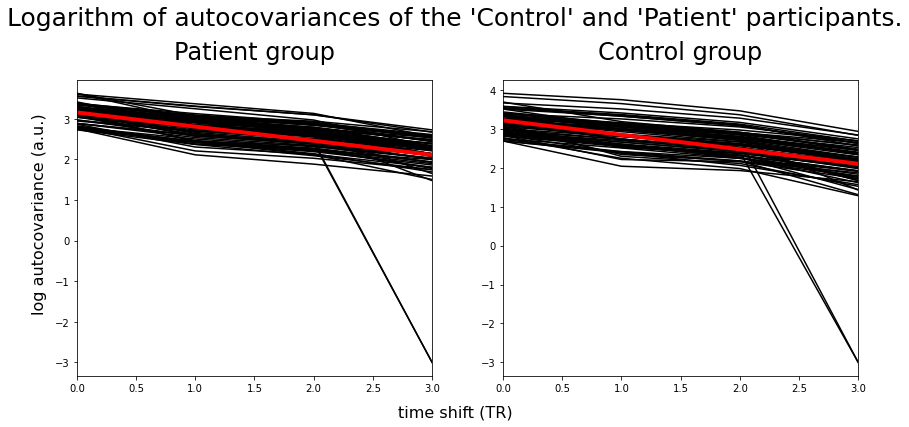

In [161]:
## Calculate the logarithm of the autocovariance.
ylim = -3
suptitle_fontsize = 25
title_fontsize = 24
axis_lable_fontsize = 16
top_adjust = 0.81

if multiple_runs_flag:
    ac = FC_avg[:, :, :, :].diagonal(axis1=2, axis2=3)
    log_ac = np.log10(np.maximum(ac[:, :, :], pow(10, ylim)))
    v_tau = np.arange(ac.shape[1], dtype=np.float)

    # Show the autocovariance for the rest run.
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    fig.suptitle(str("Autocovariances of the '" + run_labels[0]+"' and '"
                     + run_labels[1] + "' run."), fontsize=suptitle_fontsize)
    fig.subplots_adjust(top=top_adjust)
    fig.text(0.5, 0.03, 'time shift (TR)',
             ha='center', fontsize=axis_lable_fontsize)
    fig.text(0.08, 0.5, 'log autocovariance (a.u.)', va='center',
             rotation='vertical', fontsize=axis_lable_fontsize)
    plt.subplot(121)
    plt.plot(range(n_shifts), log_ac[_I_REST_RUN,:,:], '-k')
    lin_reg_rest = np.polyfit( np.repeat(v_tau, n_rois), 
                              log_ac[_I_REST_RUN,:,:].reshape(-1), 1 )
    plt.plot(v_tau, lin_reg_rest[0]*v_tau + lin_reg_rest[1], '-r', linewidth=4)
    plt.title('rest', fontsize=title_fontsize, y=1.05)
    plt.ylim((ylim, 0))
    plt.xlim((0, n_shifts-1))

    # Show the autocovariance for the nBack run.
    plt.subplot(122)
    plt.plot(range(n_shifts), log_ac[_I_NBACK_RUN,:,:], '-k')
    lin_reg_nback = np.polyfit(np.repeat(v_tau, n_rois), 
                               log_ac[_I_NBACK_RUN,:,:].reshape(-1), 1 )
    plt.plot(v_tau, lin_reg_nback[0]*v_tau + lin_reg_nback[1], '-r', linewidth=4)
    plt.title('nBack', fontsize=title_fontsize, y=1.05)
    plt.ylim((ylim, 0))
    plt.xlim((0, n_shifts-1))
    plt.show()
else:
    ac_patients = FC_patients_avg[:, :, :].diagonal(axis1=1, axis2=2)
    log_ac_patients = np.log10(np.maximum(ac_patients[:, :], pow(10, ylim)))
    v_tau_patient = np.arange(ac_patients.shape[0], dtype=np.float)
    
    ac_controls = FC_controls_avg[:, :, :].diagonal(axis1=1, axis2=2)
    log_ac_controls = np.log10(np.maximum(ac_controls[:, :], pow(10, ylim)))
    v_tau_controls = np.arange(ac_controls.shape[0], dtype=np.float)

    # Show the logarithm of the autocovariances for patients.
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    fig.suptitle(str("Logarithm of autocovariances of the '" 
                     + participant_type_labels[0] + "' and '"
                     + participant_type_labels[1]
                     + "' participants."), fontsize=suptitle_fontsize)
    fig.subplots_adjust(top=top_adjust)
    fig.text(0.5, 0.03, 'time shift (TR)',
             ha='center', fontsize=axis_lable_fontsize)
    fig.text(0.08, 0.5, 'log autocovariance (a.u.)', va='center',
             rotation='vertical', fontsize=axis_lable_fontsize)
    plt.subplot(121)
    plt.plot(range(n_shifts), log_ac_patients[:,:], '-k')
    lin_reg_patients = np.polyfit( np.repeat(v_tau_patient, n_rois), 
                              log_ac_patients[:,:].reshape(-1), 1 )
    plt.plot(v_tau_patient, lin_reg_patients[0]*v_tau_patient
             + lin_reg_patients[1], '-r', linewidth=4)
    plt.title('Patient group', fontsize=title_fontsize, y=1.05)
    #plt.ylim((ylim, 0))
    plt.xlim((0, n_shifts-1))
    
    # Show the logarithm of the autocovariances for control subjects.
    plt.subplot(122)
    plt.plot(range(n_shifts), log_ac_controls[:,:], '-k')
    lin_reg_controls = np.polyfit(np.repeat(v_tau_controls, n_rois), 
                               log_ac_controls[:,:].reshape(-1), 1 )
    plt.plot(v_tau_controls, lin_reg_controls[0]*v_tau_controls
             + lin_reg_controls[1], '-r', linewidth=4)
    plt.title('Control group', fontsize=title_fontsize, y=1.05)
    #plt.ylim((ylim, 0))
    plt.xlim((0, n_shifts-1))
    plt.show()

### Structural connectivity (SC)
The SC-matrix can be found at http://dutchconnectomelab.nl/ under the title 'Group-averaged binary connectivity matrix based on 50 healthy subjects. Data as used in the paper "Edge-centric perspective on the human connectome: link communities in the brain", De Reus et al. 2014, Philosophical Transactions of the Royal Society B. Oct 5;369(1653).' in the download section. Although this matrix is not the one used in the paper, it looks like the best alternative, for the paper does not provide a reference to the original matrix.

Typically, structural connectivity indicates 'the probability or the density of white-matter projections between pairs of ROIs in the parcellation. The algorithm that fits the model to the functional data (BOLD signals) only uses the information about whether there is a connection or not between two ROIs, to decide whether the corresponding weight is optimized.' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) So, the downloaded binary matrix is completely sufficient for the purpose of reproducing the results from the abovementioned [Senden et al. (2017)](#references) paper.

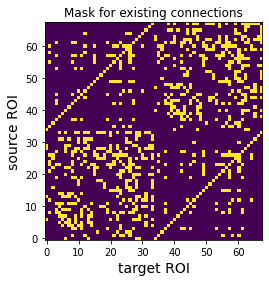

In [162]:
## Include structural connectivity.
# Load the binary structural connectivity matrix.
mask_EC = np.array(loadmat('BOLD_data_and_SC_matrix/BINARY_EC_MASK.mat')
                   ['grouped_umcu50_60percent'], dtype=bool)
# Enforce hermispheric connections.
for i in range(int(n_rois/2)):
    mask_EC[i, int(n_rois/2)+i] = True
    mask_EC[int(n_rois/2)+i, i] = True
    
# Visualise the binary structural connectivity mask.
plt.figure()
plt.imshow(mask_EC, origin='lower')
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('Mask for existing connections', fontsize=12)
plt.show()

if allow_all_connections_for_EC_flag == True:
    mask_EC = None

### MOU-EC estimation
'The optimization procedure tunes the parameters of the MOU model, namely the directional connectivity ($C$, referred to as MOU-EC) and the input covariance ($\Sigma$). It is a gradient descent that aims to minimize the matrix distance between the model and empirical covariances (referred to as spatiotemporal FC). In practice, it is encapsulated in the *fit* method of the *MOU* class. For a tutorial of the use of the MOU class for simulation and estimation, check the [*MOU_Simulation_Estimation* notebook](#references).

The optimization algorithm works with learning rates for the connectivity and the input covariance ($\epsilon_C$ and $\epsilon_\Sigma$). If they are too fast, the fitting procedure may end up being stuck in a worse local minimum than what is achievable with smaller learning rates.' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) In the paper (ct. [Senden et al. (2017)](#references)) $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ were chosen. For quicker but less finely graduated otimization try $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ with `mou_model.fit(filtered_ts_emp[i_sub,i_run,:,:].T, mask_C=mask_EC, mask_Sigma=mask_Sigma, epsilon_C=0.001, epsilon_Sigma=0.1)`.

All parameters/restrictions not explicitly passed to the fit@MOU method, have the correct defaults in fit_LO@MOU.

Depending on the value of $\epsilon_C$ the following cell might take about 30 minutes ($\epsilon_C = 0.0001) and more to run through.

In [163]:
## Calculate EC-matrix for patients.
# Construct diagonal mask for input noise matrix
# (here, no input cross-correlation).
mask_Sigma = np.eye(n_rois_patients, dtype=bool)

# Run the model optimization.
# Initialize the source arrays.
# Jacobian (off-diagonal elements = EC)
J_mod_patients = np.zeros([n_rois_patients, n_rois_patients])
J_mod_controls = np.zeros([n_rois_patients, n_rois_patients])
# Local variance (input covariance matrix, chosen to be diagonal)
Sigma_mod_patients = np.zeros([n_rois_patients, n_rois_patients])
Sigma_mod_controls = np.zeros([n_rois_patients, n_rois_patients])
# Model error
dist_mod_patients = np.zeros([1])
dist_mod_controls = np.zeros([1])
# Approximation of variance about the fitted data (FC covariance matrices)
R2_mod_patients = np.zeros([1])
R2_mod_controls = np.zeros([1])
# Between-region EC matrix
C_mod_patients = np.zeros([n_rois_patients, n_rois_patients])
C_mod_controls = np.zeros([n_rois_patients, n_rois_patients])

C = np.zeros([n_rois_patients, n_rois_patients])
i_tau_opt = 1

## Run the estimation of model parameters for patients.
if optimize_with_FC_version == 'FC_scaled_avg':
    FC = FC_patients_scaled_avg
elif optimize_with_FC_version == 'FC_avg_scaled':
    FC = FC_patients_avg_scaled
elif optimize_with_FC_version == 'FC_avg':
    FC = FC_patients_avg
else:
    print("!!!WARNING: Invalid Expression for the flag\
    'optimize_with_scaled_FC'!!! Valid terms are\n\
    'FC_patients_scaled_avg', 'FC_patients_avg_scaled',\
    'FC_patients_avg' (default).")
    FC = FC_patients_avg

mou_model = MOU(C=C) # Pass C in order to make n_nodes known to MOU().
mou_model.fit_LO(FC, i_tau_opt, mask_Sigma=mask_Sigma, 
                 mask_C=mask_EC)
# Organize the optimization results into arrays.
# Extract Jacobian of the model.
J_mod_patients[:, :] = mou_model.J
# Extract noise (auto-)covariance matrix.
Sigma_mod_patients[:, :] = mou_model.Sigma
# Extract the matrix distance between the empirical objective
# covariances and their model counterparts
# (normalized for each objective matrix).
dist_mod_patients = mou_model.d_fit['distance']
# The squared Pearson correlation is taken as an approximation
# of the variance.
R2_mod_patients = mou_model.d_fit['correlation']**2
# The between-region EC matrix of the model
C_mod_patients[:, :] = mou_model.get_C()

print('group:', participant_type_labels[1], ';\t model error, R2:',
      dist_mod_patients, R2_mod_patients)

# Store the results in files.
np.save(_RES_DIR + 'FC_patients.npy',
        FC_patients)  # Empirical spatiotemporal FC
np.save(_RES_DIR + 'mask_EC.npy',
        mask_EC)  # Mask of optimized connections
np.save(_RES_DIR + 'mask_Sigma.npy',
        mask_Sigma)  # Mask of optimized Sigma elements
np.save(_RES_DIR + 'Sigma_mod_patients.npy',
        Sigma_mod_patients)  # Estimated Sigma matrices
np.save(_RES_DIR + 'dist_mod_patients.npy',
        dist_mod_patients)  # Model error
np.save(_RES_DIR + 'J_mod_patients.npy',
        J_mod_patients)  # Estimated Jacobian, EC + inverse time const. on diag.

## Run the estimation of model parameters for controls.
if optimize_with_FC_version == 'FC_scaled_avg':
    FC = FC_controls_scaled_avg
elif optimize_with_FC_version == 'FC_avg_scaled':
    FC = FC_controls_avg_scaled
elif optimize_with_FC_version == 'FC_avg':
    FC = FC_controls_avg
else:
    print("!!!WARNING: Invalid Expression for the flag\
    'optimize_with_scaled_FC'!!! Valid terms are\n\
    'FC_patients_scaled_avg', 'FC_patients_avg_scaled',\
    'FC_patients_avg' (default).")
    FC = FC_controls_avg

mou_model = MOU(C=C) # Pass C in order to make n_nodes known to MOU().
mou_model.fit_LO(FC, i_tau_opt, mask_Sigma=mask_Sigma, 
                 mask_C=mask_EC)
# Organize the optimization results into arrays.
# Extract Jacobian of the model.
J_mod_controls[:, :] = mou_model.J
# Extract noise (auto-)covariance matrix.
Sigma_mod_controls[:, :] = mou_model.Sigma
# Extract the matrix distance between the empirical objective
# covariances and their model counterparts
# (normalized for each objective matrix).
dist_mod_controls = mou_model.d_fit['distance']
# The squared Pearson correlation is taken as an approximation
# of the variance.
R2_mod_controls = mou_model.d_fit['correlation']**2
# The between-region EC matrix of the model
C_mod_controls[:, :] = mou_model.get_C()

print('group:', participant_type_labels[0], ';\t model error, R2:',
      dist_mod_controls, R2_mod_controls)

# Store the results in files.
np.save(_RES_DIR + 'FC_controls.npy',
        FC_controls)  # Empirical spatiotemporal FC
np.save(_RES_DIR + 'Sigma_mod_controls.npy',
        Sigma_mod_controls)  # Estimated Sigma matrices
np.save(_RES_DIR + 'dist_mod_controls.npy',
        dist_mod_controls)  # Model error
np.save(_RES_DIR + 'J_mod_controls.npy',
        J_mod_controls)  # Estimated Jacobian, EC + inverse time const. on diag.
print('\nFinished.')

group: Patient ;	 model error, R2: 0.685818502298063 0.5645250296518439
group: Control ;	 model error, R2: 0.6099025242346141 0.671499690034321

Finished.


# <p style="text-align: center;"> <span style="color:red">*After optimization!*</span></p>

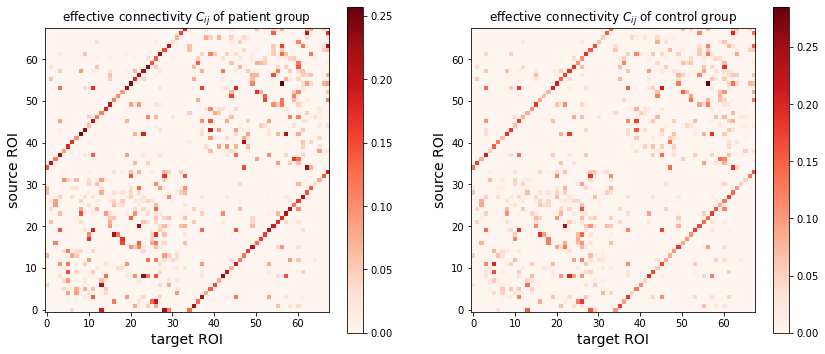

In [164]:
# Plot C-matrix for resting state data.
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.imshow(C_mod_patients[:, :], origin='lower', cmap='Reds')
plt.colorbar()
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('effective connectivity $C_{ij}$ of patient group')
plt.subplot(122)
plt.imshow(C_mod_controls[:, :], origin='lower', cmap='Reds')
plt.colorbar()
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('effective connectivity $C_{ij}$ of control group')
plt.show()

### Local variability
As in the paper, local variability ($\Sigma$) is split up into the part exhibited by the rich club and the one exhibited by the peripheral regions.

In [165]:
## Calculate local variability for rich club and periphery.
# Create a 1D-mask for rich club regions.
mask_rc = np.zeros(n_rois, dtype=bool)
indexes_rich_club = [23, 26, 27, 57, 60, 61]
mask_rc[indexes_rich_club] = True
print('Rich club regions:\n',
      roi_labels[indexes_rich_club].tolist())
      #np.concatenate(roi_labels[indexes_rich_club]).tolist())

# Examine the patients group.
local_var_patients = Sigma_mod_patients[:, :].diagonal()
local_var = local_var_patients
rc_var = local_var[mask_rc]
periph_var = local_var[~mask_rc]
mean_rc_var = rc_var.mean() # avarage over regions
mean_periph_var = periph_var.mean() # avarage over regions
conf_int_rc = np.array(stt.t.interval(
    0.95, rc_var.shape[0]-1, loc=mean_rc_var, 
    scale=stt.sem(rc_var)))
conf_int_periph = np.array(stt.t.interval(
    0.95, periph_var.shape[0]-1, loc=mean_periph_var, 
    scale=stt.sem(periph_var)))
print('\nPatients group:')
print('Mean of local variability (rich club):\n', str(mean_rc_var))
print('Mean of local variability (periphery):\n', str(mean_periph_var))
print('95% confidence interval (rich club):\n', conf_int_rc)
print('95% confidence interval (periphery):\n', conf_int_periph)

# Examine the control group.
local_var_controls = Sigma_mod_controls[:, :].diagonal()
local_var = local_var_controls
rc_var = local_var[mask_rc]
periph_var = local_var[~mask_rc]
mean_rc_var = rc_var.mean() # avarage over regions
mean_periph_var = periph_var.mean() # avarage over regions
conf_int_rc = np.array(stt.t.interval(
    0.95, rc_var.shape[0]-1, loc=mean_rc_var, 
    scale=stt.sem(rc_var)))
conf_int_periph = np.array(stt.t.interval(
    0.95, periph_var.shape[0]-1, loc=mean_periph_var, 
    scale=stt.sem(periph_var)))
print('\nControl group:')
print('Mean of local variability (rich club):\n', str(mean_rc_var))
print('Mean of local variability (periphery):\n', str(mean_periph_var))
print('95% confidence interval (rich club):\n', conf_int_rc)
print('95% confidence interval (periphery):\n', conf_int_periph)

Rich club regions:
 ['lh_precuneus', 'lh_superiorfrontal', 'lh_superiorparietal', 'rh_precuneus', 'rh_superiorfrontal', 'rh_superiorparietal']

Patients group:
Mean of local variability (rich club):
 0.1847657209247865
Mean of local variability (periphery):
 0.24176554560414748
95% confidence interval (rich club):
 [0.10431356 0.26521788]
95% confidence interval (periphery):
 [0.2061084  0.27742269]

Control group:
Mean of local variability (rich club):
 0.1612118997528967
Mean of local variability (periphery):
 0.2034635872411933
95% confidence interval (rich club):
 [0.09010742 0.23231638]
95% confidence interval (periphery):
 [0.17555177 0.23137541]


In [166]:
## Cluster-based bootstrapping according to section 2.5
n_samples = 10000
length_of_sample = len(indexes_rich_club)
roi_indexes = np.arange(n_rois)

# Examine the patients group.
samples_patients = np.zeros([n_samples])
for i_sample in range(n_samples):
    i_index_sample = np.random.choice(roi_indexes, size=6)
    mask_i_sample = np.zeros(n_rois, dtype=bool)
    mask_i_sample[i_index_sample] = True
    samples_patients[i_sample] = local_var_patients[mask_i_sample].mean()

# Examine the control group.
samples_controls = np.zeros([n_samples])
for i_sample in range(n_samples):
    i_index_sample = np.random.choice(roi_indexes, size=6)
    mask_i_sample = np.zeros(n_rois, dtype=bool)
    mask_i_sample[i_index_sample] = True
    samples_controls[i_sample] = local_var_controls[mask_i_sample].mean()     

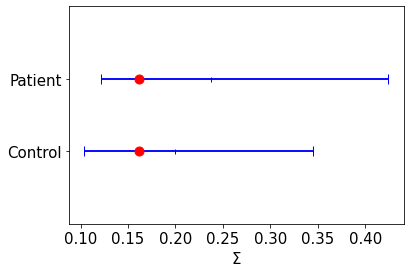

In [167]:
## Reproduce FIGURE 3a)

# Examine the patients group.
rankordered_samples = np.sort(samples_patients)
rankordered_samples = rankordered_samples[25:9975]
xerr = rankordered_samples[[0,-1]]

y = np.ones([2])
fontsize = 15
markersize = 18

fig = plt.figure()
plt.hlines(y, xmin=xerr[0], xmax=xerr[1], color='b')
plt.plot(xerr, y, '|', color='b', markersize=10)
plt.plot(rankordered_samples.mean(), y[0], '|', color='b', markersize=5)
plt.xticks(fontsize=fontsize)
#plt.ylim([0.5, 5.5])
plt.xlabel('$\Sigma$', fontsize=fontsize)

if mean_rc_var > xerr[1] or mean_rc_var < xerr[0]:
    formatstring = '.g'
else:
    formatstring = '.r'
plt.plot(mean_rc_var, y[0], formatstring, markersize=markersize)

# Examine the control group.
rankordered_samples = np.sort(samples_controls)
rankordered_samples = rankordered_samples[25:9975]
xerr = rankordered_samples[[0,-1]]

y = np.ones([2])*0.5
fontsize = 15
markersize = 18

plt.hlines(y, xmin=xerr[0], xmax=xerr[1], color='b')
plt.plot(xerr, y, '|', color='b', markersize=10)
plt.plot(rankordered_samples.mean(), y[0], '|', color='b', markersize=5)
plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylim([0, 1.5])
plt.xlabel('$\Sigma$', fontsize=fontsize)

if mean_rc_var > xerr[1] or mean_rc_var < xerr[0]:
    formatstring = '.g'
else:
    formatstring = '.r'
plt.plot(mean_rc_var, y[0], formatstring, markersize=markersize)
plt.show()

### Input-output ratio
The information flow between regions is encapsulated in the $C$-matrix. In order to test the hypotheses that the rich club might gate the input it receives from peripheral regions, the inter-rich-club-connections are ignored. This means that only the information flow from and to the rich club is examined when it comes to the inspection of the rich club input-output-ratio.

The input-output ratio of the periphery takes into account all inter-periphery activity (exclusively).


Patient group:
Mean input-to-output ratio of the rich club:
 0.814929689078027
95% confidence interval (rich club):
 [0.37319889 1.25666049]
Total income to total outcome ratio of the rich club:
 0.6593076316311464
Mean input-to-output ratio of the priphery:
 1.1333996020565456
95% confidence interval (periphery):
 [1.02604485 1.24075436]
Total income to total outcome ratio of the priphery:
 1.0

Control group:
Mean input-to-output ratio of the rich club:
 0.7762616997886239
95% confidence interval (rich club):
 [0.35518832 1.19733508]
Total income to total outcome ratio of the rich club:
 0.6372103153346652
Mean input-to-output ratio of the priphery:
 1.1428127923674183
95% confidence interval (periphery):
 [1.02706614 1.25855944]
Total income to total outcome ratio of the priphery:
 0.9999999999999999


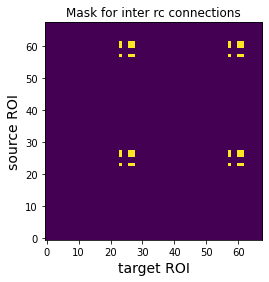

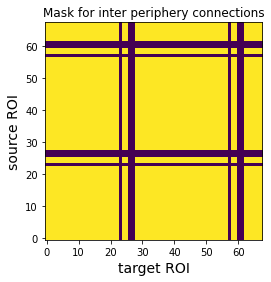

In [168]:
## Calculate the input-to-output ratio of total incoming/outgoing EC.
if input_is_rowsum_flag == True:
    inputAxis = 0
    outputAxis = 1
else:
    inputAxis = 1
    outputAxis = 0

# Create a 2D-mask for inter rich club connections.
mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
rc_ind_combin = np.array(list(
    itertools.product(indexes_rich_club, repeat=2))).T
mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True



## Examine the patients group.
# Calculate the ratio of incoming/outgoing EC from and to the rich club
no_rc_connections_C = np.copy(C_mod_patients)
no_rc_connections_C[mask_inter_rc] = 0
if io_based_on_nodal_degree_flag == True:
    roi_input = np.squeeze(np.count_nonzero(no_rc_connections_C,
                                            axis=inputAxis, keepdims=True))
    roi_output = np.squeeze(np.count_nonzero(no_rc_connections_C,
                                             axis=outputAxis, keepdims=True))
else:
    roi_input = no_rc_connections_C[:, :].sum(axis=inputAxis)
    roi_output = no_rc_connections_C[:, :].sum(axis=outputAxis)
    #roi_input = C_mod[:, :, :].sum(axis=1)
    #roi_output = C_mod[:, :, :].sum(axis=2)
io_rc = roi_input[mask_rc] / roi_output[mask_rc]
# Calculate and print the mean io-ratio and the CI for rich club regions
mean_rc_io = io_rc[:].mean()
conf_int_rc = np.array(stt.t.interval(
    0.95, io_rc.shape[0]-1, loc=mean_rc_io, 
    scale=stt.sem(io_rc)))
print('\nPatient group:')
print('Mean input-to-output ratio of the rich club:\n', str(mean_rc_io))
print('95% confidence interval (rich club):\n', str(conf_int_rc))
rc_ratio_of_total_io_patients = (roi_input[mask_rc].sum()
                        / roi_output[mask_rc].sum())
print('Total income to total outcome ratio of the rich club:\n',
      str(rc_ratio_of_total_io_patients))
# Create a 2D-mask for inter periphery connections.
mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
periph_ind_combin = np.array(list(itertools.product(list(
    x for x in range(68) if x not in indexes_rich_club), repeat=2))).T
mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
# Calculate the ratio of incoming/outgoing EC among peripheral regions 
only_periph_connections_C = np.copy(C_mod_patients)
only_periph_connections_C[~mask_inter_periph] = 0
if io_based_on_nodal_degree_flag == True:
    roi_input = np.squeeze(np.count_nonzero(only_periph_connections_C,
                                            axis=inputAxis, keepdims=True))
    roi_output = np.squeeze(np.count_nonzero(only_periph_connections_C,
                                             axis=outputAxis, keepdims=True))
else:
    roi_input = only_periph_connections_C[:, :].sum(axis=inputAxis)
    roi_output = only_periph_connections_C[:, :].sum(axis=outputAxis)
io_periph = (roi_input[~mask_rc] / roi_output[~mask_rc])
# Calculate and print the mean io-ratio and the CI for peripheral regions
mean_periph_io = io_periph.mean()
conf_int_periph = np.array(stt.t.interval(
    0.95, io_periph.shape[0]-1, loc=mean_periph_io, 
    scale=stt.sem(io_periph)))
print('Mean input-to-output ratio of the priphery:\n', str(mean_periph_io))
print('95% confidence interval (periphery):\n', str(conf_int_periph))
periph_ratio_of_total_io = (roi_input[~mask_rc].sum()
                            / roi_output[~mask_rc].sum())
print('Total income to total outcome ratio of the priphery:\n',
      str(periph_ratio_of_total_io))


## Examine the control group.
# Calculate the ratio of incoming/outgoing EC from and to the rich club
no_rc_connections_C = np.copy(C_mod_controls)
no_rc_connections_C[mask_inter_rc] = 0
if io_based_on_nodal_degree_flag == True:
    roi_input = np.squeeze(np.count_nonzero(no_rc_connections_C,
                                            axis=inputAxis, keepdims=True))
    roi_output = np.squeeze(np.count_nonzero(no_rc_connections_C,
                                             axis=outputAxis, keepdims=True))
else:
    roi_input = no_rc_connections_C[:, :].sum(axis=inputAxis)
    roi_output = no_rc_connections_C[:, :].sum(axis=outputAxis)
    #roi_input = C_mod[:, :, :].sum(axis=1)
    #roi_output = C_mod[:, :, :].sum(axis=2)
io_rc = roi_input[mask_rc] / roi_output[mask_rc]
# Calculate and print the mean io-ratio and the CI for rich club regions
mean_rc_io = io_rc[:].mean()
conf_int_rc = np.array(stt.t.interval(
    0.95, io_rc.shape[0]-1, loc=mean_rc_io, 
    scale=stt.sem(io_rc)))
print('\nControl group:')
print('Mean input-to-output ratio of the rich club:\n', str(mean_rc_io))
print('95% confidence interval (rich club):\n', str(conf_int_rc))
rc_ratio_of_total_io_controls = (roi_input[mask_rc].sum()
                        / roi_output[mask_rc].sum())
print('Total income to total outcome ratio of the rich club:\n',
      str(rc_ratio_of_total_io_controls))
# Create a 2D-mask for inter periphery connections.
mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
periph_ind_combin = np.array(list(itertools.product(list(
    x for x in range(68) if x not in indexes_rich_club), repeat=2))).T
mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
# Calculate the ratio of incoming/outgoing EC among peripheral regions 
only_periph_connections_C = np.copy(C_mod_controls)
only_periph_connections_C[~mask_inter_periph] = 0
if io_based_on_nodal_degree_flag == True:
    roi_input = np.squeeze(np.count_nonzero(only_periph_connections_C,
                                            axis=inputAxis, keepdims=True))
    roi_output = np.squeeze(np.count_nonzero(only_periph_connections_C,
                                             axis=outputAxis, keepdims=True))
else:
    roi_input = only_periph_connections_C[:, :].sum(axis=inputAxis)
    roi_output = only_periph_connections_C[:, :].sum(axis=outputAxis)
io_periph = (roi_input[~mask_rc] / roi_output[~mask_rc])
# Calculate and print the mean io-ratio and the CI for peripheral regions
mean_periph_io = io_periph.mean()
conf_int_periph = np.array(stt.t.interval(
    0.95, io_periph.shape[0]-1, loc=mean_periph_io, 
    scale=stt.sem(io_periph)))
print('Mean input-to-output ratio of the priphery:\n', str(mean_periph_io))
print('95% confidence interval (periphery):\n', str(conf_int_periph))
periph_ratio_of_total_io = (roi_input[~mask_rc].sum()
                            / roi_output[~mask_rc].sum())
print('Total income to total outcome ratio of the priphery:\n',
      str(periph_ratio_of_total_io))

plt.figure()
plt.imshow(mask_inter_rc, origin='lower')
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('Mask for inter rc connections', fontsize=12)
plt.show()

plt.figure()
plt.imshow(mask_inter_periph, origin='lower')
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('Mask for inter periphery connections', fontsize=12)
plt.show()

In [169]:
## Cluster-based bootstrapping according to section 2.5
## Examine the patients group. 
n_samples = 10000
length_of_sample = len(indexes_rich_club)
roi_indexes = np.arange(n_rois)

samples_patients = np.zeros([n_samples])
for i_sample in range(n_samples):
    i_index_sample = np.random.choice(roi_indexes, size=6)
    mask_i_sample = np.zeros(n_rois, dtype=bool)
    mask_i_sample[i_index_sample] = True

    mask_inter_sample = np.zeros([n_rois, n_rois], dtype=bool)
    sample_index_combin = np.array(list(
        itertools.product(i_index_sample, repeat=2))).T
    mask_inter_rc[sample_index_combin[0], sample_index_combin[1]] = True
    # Calculate the ratio of incoming/outgoing EC from and to the sample
    no_inter_sample_connections_C = np.copy(C_mod_patients[:, :])
    no_inter_sample_connections_C[mask_inter_sample] = 0
    # io ratio represented through nodal degree 
    if io_based_on_nodal_degree_flag:
        roi_input = np.squeeze(np.count_nonzero(
            no_inter_sample_connections_C, axis=inputAxis, 
            keepdims=True))
        roi_output = np.squeeze(np.count_nonzero(
            no_inter_sample_connections_C, axis=outputAxis, 
            keepdims=True))
    else:
        roi_input = no_inter_sample_connections_C[:, :].sum(
            axis=inputAxis)
        roi_output = no_inter_sample_connections_C[:, :].sum(
            axis=outputAxis)

    samples_patients[i_sample] = (roi_input[mask_i_sample].sum() /
                                roi_output[mask_i_sample].sum())

## Examine the control group.
samples_controls = np.zeros([n_samples])
for i_sample in range(n_samples):
    i_index_sample = np.random.choice(roi_indexes, size=6)
    mask_i_sample = np.zeros(n_rois, dtype=bool)
    mask_i_sample[i_index_sample] = True

    mask_inter_sample = np.zeros([n_rois, n_rois], dtype=bool)
    sample_index_combin = np.array(list(
        itertools.product(i_index_sample, repeat=2))).T
    mask_inter_rc[sample_index_combin[0], sample_index_combin[1]] = True
    # Calculate the ratio of incoming/outgoing EC from and to the sample
    no_inter_sample_connections_C = np.copy(C_mod_controls[:, :])
    no_inter_sample_connections_C[mask_inter_sample] = 0
    # io ratio represented through nodal degree 
    if io_based_on_nodal_degree_flag:
        roi_input = np.squeeze(np.count_nonzero(
            no_inter_sample_connections_C, axis=inputAxis, 
            keepdims=True))
        roi_output = np.squeeze(np.count_nonzero(
            no_inter_sample_connections_C, axis=outputAxis, 
            keepdims=True))
    else:
        roi_input = no_inter_sample_connections_C[:, :].sum(
            axis=inputAxis)
        roi_output = no_inter_sample_connections_C[:, :].sum(
            axis=outputAxis)

    samples_controls[i_sample] = (roi_input[mask_i_sample].sum() /
                                roi_output[mask_i_sample].sum())

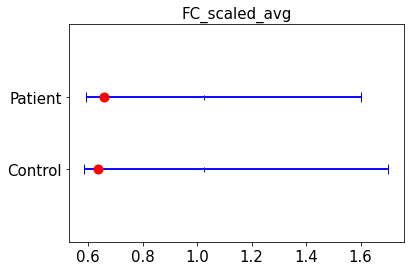

In [170]:
## Reproduce FIGURE 3c)
## Examine the patients group.
# Plot CI with marks for the mean and the endpoints
rankordered_samples = np.sort(samples_patients)
rankordered_samples = rankordered_samples[25:9975] # 95 percentile
xerr = rankordered_samples[[0,-1]]
fontsize = 15
fig = plt.figure()
plt.hlines([1, 1], xmin=xerr[0], xmax=xerr[1], color='b')
plt.plot(xerr, [1, 1], '|', color='b', markersize=10)
plt.plot(rankordered_samples.mean(), [1], '|', color='b', markersize=5)
plt.xticks(fontsize=fontsize)
# Plot RC io ratio (red = not significant, green = significant)
io_ratio = rc_ratio_of_total_io_patients
formatstring = '.r'
if io_ratio > xerr[1] or io_ratio < xerr[0]:
    formatstring = '.g' 
plt.plot(io_ratio, [1], formatstring, markersize=18)

## Examine the control group.
# Plot CI with marks for the mean and the endpoints
rankordered_samples = np.sort(samples_controls)
rankordered_samples = rankordered_samples[25:9975] # 95 percentile
xerr = rankordered_samples[[0,-1]]
plt.hlines([0.5, 0.5], xmin=xerr[0], xmax=xerr[1], color='b')
plt.plot(xerr, y, '|', color='b', markersize=10)
plt.plot(rankordered_samples.mean(), [0.5], '|', color='b', markersize=5)
plt.xticks(fontsize=fontsize)
plt.ylim([0, 1.5])
# Plot RC io ratio (red = not significant, green = significant)
io_ratio = rc_ratio_of_total_io_controls
formatstring = '.r'
if io_ratio > xerr[1] or io_ratio < xerr[0]:
    formatstring = '.g' 
plt.plot(io_ratio, [0.5], formatstring, markersize=18)
plt.title(optimize_with_FC_version, fontsize=fontsize)
plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
plt.show()
#fig.savefig('rc_significant_choice_nodal_degree_FC_avg.png', bbox_inches='tight')

### References
<a id='references'></a>
MOUEC-Estimation notebook by Gilson et al. (2019): Andrea Insabato, Gorka Zamora-López, Matthieu Gilson 1_MOUEC_Estimation.ipynb. 2019. https://github.com/mb-BCA/notebooks_review2019/blob/master/1_MOUEC_Estimation.ipynb

*MOU_Simulation_Estimation* notebook: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson MOU_Simulation_Estimation.ipynb. 2019. https://github.com/mb-BCA/pyMOU/blob/master/examples/MOU_Simulation_Estimation.ipynb

*pyMOU* library: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson. 2019. https://github.com/mb-BCA/pyMOU 

Senden et al. (2017): M. Senden, N. Reuter, M. P. van den Heuvel, R. Goebel, G. Deco, and M. Gilson. Task-related effective connectivity reveals that the cortical rich club gates cortex-wide communication. Hum Brain Mapp, 2017. https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23913